In [ ]:
import numpy as np
import datetime
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Activation, LSTM, SimpleRNN
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import csv
import pickle
import os

In [ ]:
df = pd.read_csv(os.path.join('..', 'datasets', 'combined_fortunes-4632.csv'), header=None)
df.columns = ['fortunes']

In [ ]:
# Count NaN values in the specified column
nan_count = df['fortunes'].isna().sum()
print(f"Number of NaN values in 'fortunes': {nan_count}")

# Drop rows where the specified column has NaN values
if nan_count != 0:
  df = df.dropna(subset=['fortunes'])

Number of NaN values in 'fortunes': 1


In [ ]:
# Assuming you have already loaded the DataFrame df
df['fortunes'] = df['fortunes'].str.lower()
df.head()

,fortunes
0,text
1,a bad beginning makes a bad ending.
2,a bad corn promise is better than a good lawsuit.
3,a bad workman quarrels with his tools.
4,a bargain is a bargain.


In [ ]:
# Combine all sentences into one string
text = ' '.join(df['fortunes'])
text

'text a bad beginning makes a bad ending. a bad corn promise is better than a good lawsuit. a bad workman quarrels with his tools. a bargain is a bargain. a beggar can never be bankrupt. a bird in the hand is worth two in the bush. a bird may be known by its song. a black hen lays a white egg. a blind leader of the blind. a blind man would be glad to see. a broken friendship may be soldered, but will never be sound. a burden of one\'s own choice is not felt. a burnt child dreads the fire. a cat in gloves catches no mice. a city that parley is half gotten. a civil denial is better than a rude grant. a clean fast is better than a dirty breakfast. a clean hand wants no washing. a clear conscience laughs at false accusations. a close mouth catches no flies. a cock is valiant on his own dunghill. a cracked bell can never sound well. a creaking door hangs long on its hinges. a curse cow has short horns. a danger foreseen is half avoided. a drop in the bucket. a drowning man will catch at a s

In [ ]:
# set of characters that occur in the text
chars = set([c for c in text])
# Total items in our vocabulary
nb_chars = len(chars)
# lookup tables to deal with indexes of characters rather than the characters themselves.
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))


In [ ]:
SEQLEN = 20
STEP = 1
input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i:i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


In [ ]:
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=bool)
y = np.zeros((len(input_chars), nb_chars), dtype=bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)


In [ ]:
NUM_ITERATIONS = 50
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100
# Perform a grid search for batch size, hidden size, and learning rate
batch_sizes = [64, 128, 256]
hidden_sizes = [128, 256, 512]
learning_rates = [0.001, 0.01, 0.1]

for batch_size in batch_sizes:
    for hidden_size in hidden_sizes:
        for learning_rate in learning_rates:
            model = Sequential()
            model.add(SimpleRNN(hidden_size, return_sequences=False, input_shape=(SEQLEN, nb_chars)))
            model.add(Dense(nb_chars))
            model.add(Activation("softmax"))

            custom_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(loss="categorical_crossentropy", optimizer=custom_optimizer, metrics=["accuracy"])

            log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1,
                write_graph=True,
                write_images=True
            )

            early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-2,
                                                                       verbose=2, mode="min")

            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

            history = model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=NUM_EPOCHS_PER_ITERATION * NUM_ITERATIONS,
                validation_data=(X_valid, y_valid),
                callbacks=[tensorboard_callback, early_stopping_callback]
            )

            # Print the hyperparameters and the final training loss
            print(f"Batch Size: {batch_size}, Hidden Size: {hidden_size}, Learning Rate: {learning_rate}")
            print(f"Final Training Loss: {history.history['loss'][-1]}")
            print("="*50)


In [ ]:
# Choose the best hyperparameters and train the model with the entire dataset
best_batch_size = 256
best_hidden_size = 512
best_learning_rate = 0.001

In [ ]:
model = Sequential()
model.add(SimpleRNN(best_hidden_size, return_sequences=False, input_shape=(SEQLEN, nb_chars)))
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

In [ ]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=custom_optimizer, metrics=["accuracy"])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-2,
                                                           verbose=2, mode="min")

history = model.fit(
    X_train,
    y_train,
    batch_size=best_batch_size,
    epochs=NUM_EPOCHS_PER_ITERATION * NUM_ITERATIONS,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/50
822/822 [==============================] - 19s 20ms/step - loss: 2.5981 - accuracy: 0.2763 - val_loss: 2.2841 - val_accuracy: 0.3280
Epoch 2/50
822/822 [==============================] - 17s 21ms/step - loss: 2.2931 - accuracy: 0.3359 - val_loss: 2.3037 - val_accuracy: 0.3194
Epoch 3/50
822/822 [==============================] - 18s 22ms/step - loss: 2.1458 - accuracy: 0.3627 - val_loss: 2.1011 - val_accuracy: 0.3665
Epoch 4/50
822/822 [==============================] - 16s 19ms/step - loss: 2.0259 - accuracy: 0.3908 - val_loss: 2.0211 - val_accuracy: 0.3965
Epoch 5/50
822/822 [==============================] - 17s 20ms/step - loss: 1.9653 - accuracy: 0.4104 - val_loss: 3.1572 - val_accuracy: 0.2551
Epoch 6/50
822/822 [==============================] - 16s 19ms/step - loss: 2.1702 - accuracy: 0.3579 - val_loss: 2.0337 - val_accuracy: 0.3940
Epoch 7/50
822/822 [==============================] - 16s 19ms/step - loss: 2.0019 - accuracy: 0.3975 - val_loss: 1.9748 - val_accuracy:

In [ ]:
# Save the model
with open('rnnTextGeneration.pkl', 'wb') as f:
    pickle.dump(model, f)

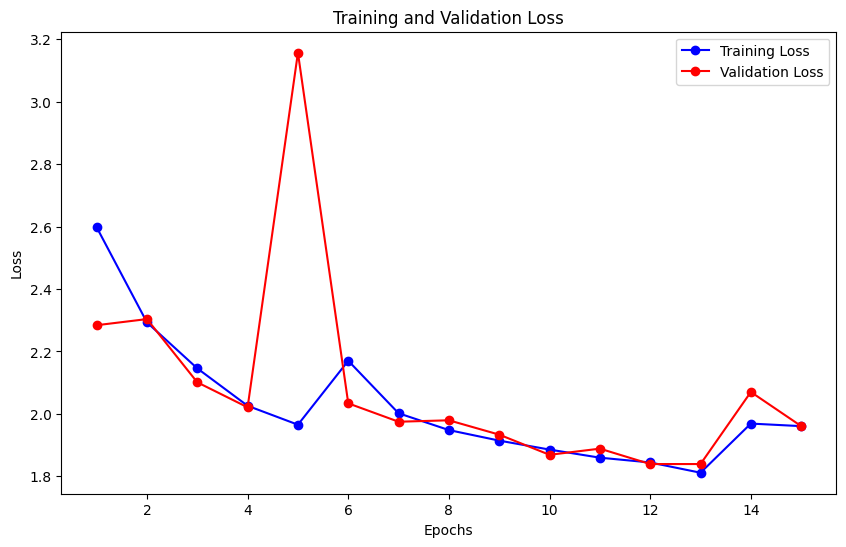

In [ ]:
import matplotlib.pyplot as plt

# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

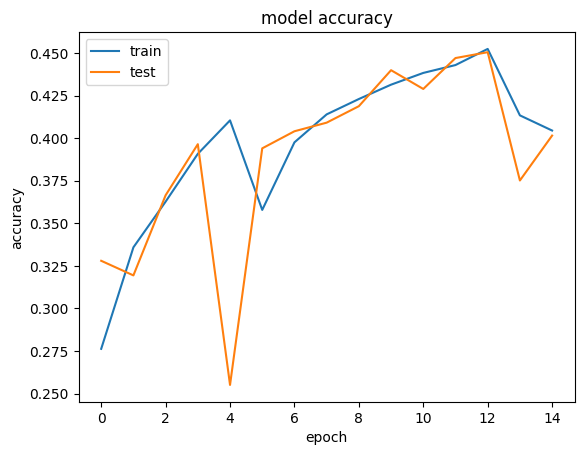

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# List of seed sentences
seed_sentences = [
    "you should beware of",
    "happiness comes from",
    "the happiness brings",
    "meaning of life is",
    "the journey of life",
    "success is achieved",
    "knowledge is the key",
    "friendship is like",
    "love is the greatest",
    "the world needs more"
]

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
generated_sequences = set()
# Generate and print 100 unique sentences using the sample function
while len(generated_sequences) < 100:
    seed_sentence = np.random.choice(seed_sentences)  # Choose a random seed sentence
    test_chars = seed_sentence
    generated_sequence = test_chars

    for i in range(500):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        preds = model.predict(Xtest, verbose=0)[0]
        next_index = sample(preds)  # Use the sample function to get the next character index
        next_char = index2char[next_index]

        generated_sequence += next_char
        if next_char == ".":
            break
        # move forward with test_chars + next_char
        test_chars = test_chars[1:] + next_char

    if generated_sequence not in generated_sequences:
        generated_sequences.add(generated_sequence)  # Add the generated sequence to the set
        print(generated_sequence + "\n" + "="*50 + "\n")  # To separate generated sentences


the world needs more aals frleld to thands, yoer hered bess the peass doad eet lay kepreseredd your nefendy a.

you should beware of arins sove to nro bad he lasten.

knowledge is the key.

success is achievedrs.

success is achieveddsoe idlossosymroslo.

the happiness brings in be cape is rendnes gres will your mysereng.

the journey of lifete adeu onen,.

meaning of life isbasvrhdssdta.

the world needs morene frery.

friendship is likee.

love is the greatest parres.

you should beware of to keans a monn merers resor toder, jon semans fing ffilet.

the world needs mored.

love is the greatest kende sion wint your it le, your nespare is yours.

friendship is likeronrddso eeedslrdsly oeer er edsfyrl.

love is the greatest.

meaning of life isoe en ae sa yand elafsisrdrsyrsesy.

meaning of life is eurdi flsdv.

you should beware of trinnterfing thinge.

knowledge is the keyed in theserserts as cweels.

friendship is likesrytrd,ndysed ae eoe eenn.

the journey of lifetetedvso honogt ove

In [ ]:
# Open CSV file in write mode
with open('generated_fortunes_rnn.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)

    # Write each generated sentence to the CSV file
    for sentence in generated_sequences:
        writer.writerow([sentence])
